# Code for Bachelor Thesis in Economics at Heidelberg University
## by Daniel Schäffer

## Imports:

In [2]:
# #standard modules
# import pandas as pd
# import numpy as np
# import os
# import re
# #plots:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# import cartopy
# import cartopy.feature as cf
# import cartopy.crs as ccrs
# import seaborn as sns
# import folium
# from folium.plugins import HeatMap, HeatMapWithTime
# #data
# from netCDF4 import Dataset
# from pandas import datetime
# #IO
# import openpyxl
# #speedup
# from numba import jit
# #animations
# from celluloid import Camera # getting the camera
# from IPython.display import HTML # to show the animation in Jupyter

from functions import (plot_merra_data, plot_outcome_data, plot_ols_data, create_population_array,
                      plot_gpw_data, create_population_weight_array,
                      daily_dust_country_regression,get_mse_data,create_dust_exposure_df,
                      process_outcome_data, create_lag_array_from_df)

from functions import create_multiple_lag_array_from_df
# from functions import plot_main_dust
import os
import pickle
import numpy as np
import pandas as pd
from netCDF4 import Dataset

import matplotlib.pyplot as plt


from functions import process_merra_data

import statsmodels.api as sm

from numba import jit


import cmocean
import cmocean.cm as cmo


In [3]:
parent_directory = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath("__file__")), os.pardir))

# 3. Empirical Strategy

## 3.3 Model Implementation

### Data

In [4]:
with open(parent_directory + '\\processed_data\\daily_novapr_indices', 'rb') as pickle_file:
        daily_novapr_indices = pickle.load(pickle_file)

with open(parent_directory + '\\processed_data\\daily_junsep_indices', 'rb') as pickle_file:
        daily_junsep_indices = pickle.load(pickle_file)


In [5]:
west_africa_longitudes = np.load(parent_directory + '\\processed_data\\west_africa_longitudes.npy')
west_africa_latitudes = np.load(parent_directory + '\\processed_data\\west_africa_latitudes.npy')

First specification, where dust is instrumented using a statistical relationship between source location dust and dust over the outcome location, dust in a given MERRA pixel on a given day is predicted using the following equation:

$$D_{pt} = \sum_{j=0}^{10} \gamma_{p,sj}D_{B,t-j} + \theta_{p}C_{pt} + \nu_{pt}$$
---
Where:
$$ D_{pt} = \text{dust in pixel p on day t}$$
$$ D_{B,t-j} = \text{mean dust over the Bodélé Depression j days prior}$$
$$ C_{pt} = \text{controls for temperature and precipitation in pixel p on day t} $$
$$ \gamma_{p,sj} = \text{depends on the pixel and the season, dry or rainy} $$

In [6]:
# np.std(aod_reg_df[(aod_reg_df['dry_season']==True)]['bod_aod_t-0'])

In [7]:
# np.std(np.std(np.std(aod_daily_data, axis = 0), axis=0), axis =0)

In [8]:
aod_reg_df = pd.read_csv(parent_directory + '\\processed_data\\togo_dust_reg_df.csv', index_col=[0])

In [9]:
aod_reg_df

togo_coast_aod  wet_season  dry_season   bod_aod_t-0   bod_aod_t-1  \
10       1.933139e-08         0.0         1.0  8.291745e-08  1.611511e-07   
11       1.930206e-08         0.0         1.0  6.580646e-08  8.291745e-08   
12       1.873379e-08         0.0         1.0  1.227917e-07  6.580646e-08   
13       2.146334e-08         0.0         1.0  2.041371e-07  1.227917e-07   
14       1.955121e-08         0.0         1.0  2.114525e-07  2.041371e-07   
...               ...         ...         ...           ...           ...   
13509    1.202285e-07         0.0         1.0  3.997843e-07  4.885330e-07   
13510    3.730335e-07         0.0         1.0  3.885522e-07  3.997843e-07   
13511    3.369520e-07         0.0         1.0  2.521374e-07  3.885522e-07   
13512    1.593101e-07         0.0         1.0  2.186806e-07  2.521374e-07   
13513    1.277088e-07         0.0         1.0  2.321826e-07  2.186806e-07   

        bod_aod_t-2   bod_aod_t-3   bod_aod_t-4   bod_aod_t-5   bod_aod_t-6  \
10     2.216467e-07  1.794047e-07  1.195725e-07  2.492426e-07  3.349612e-07   
11     1.611511e-07  2.216467e-07  1.794047e-07  1.195725e-07  2.492426e-07   
12     8.291745e-08  1.611511e-07  2.216467e-07  1.794047e-07  1.195725e-07   
13     6.580646e-08  8.291745e-08  1.611511e-07  2.216467e-07  1.794047e-07   
14     1.227917e-07  6.580646e-08  8.291745e-08  1.611511e-07  2.216467e-07   
...             ...           ...           ...           ...           ...   
13509  5.283558e-07  2.481566e-07  1.735647e-07  2.420889e-07  3.751860e-07   
13510  4.885330e-07  5.283558e-07  2.481566e-07  1.735647e-07  2.420889e-07   
13511  3.997843e-07  4.885330e-07  5.283558e-07  2.481566e-07  1.735647e-07   
13512  3.885522e-07  3.997843e-07  4.885330e-07  5.283558e-07  2.481566e-07   
13513  2.521374e-07  3.885522e-07  3.997843e-07  4.885330e-07  5.283558e-07   

        bod_aod_t-7   bod_aod_t-8   bod_aod_t-9  bod_aod_t-10  precipitation  \
10     1.915816e-07  1.442935e-07  1.444201e-07  1.064784e-07       0.000007   
11     3.349612e-07  1.915816e-07  1.442935e-07  1.444201e-07       0.000009   
12     2.492426e-07  3.349612e-07  1.915816e-07  1.442935e-07       0.000006   
13     1.195725e-07  2.492426e-07  3.349612e-07  1.915816e-07       0.000003   
14     1.794047e-07  1.195725e-07  2.492426e-07  3.349612e-07       0.000006   
...             ...           ...           ...           ...            ...   
13509  3.859321e-07  3.074284e-07  2.183490e-07  1.933918e-07       0.000000   
13510  3.751860e-07  3.859321e-07  3.074284e-07  2.183490e-07       0.000000   
13511  2.420889e-07  3.751860e-07  3.859321e-07  3.074284e-07       0.000000   
13512  1.735647e-07  2.420889e-07  3.751860e-07  3.859321e-07       0.000000   
13513  2.481566e-07  1.735647e-07  2.420889e-07  3.751860e-07       0.000000   

       temperature  
10      300.165131  
11      300.136841  
12      300.114349  
13      300.185822  
14      301.024292  
...            ...  
13509   300.930847  
13510   300.479645  
13511   299.738495  
13512   299.704315  
13513   299.968414  

[13504 rows x 16 columns]

In [10]:
aod_reg_model = sm.OLS(aod_reg_df.iloc[: ,0], sm.add_constant(aod_reg_df.iloc[: , 1:])).fit(cov_type='HC1')
#aod_reg_model = sm.OLS(aod_reg_df.iloc[: ,0], aod_reg_df.iloc[: , 1:]).fit(cov_type='HC1')
aod_reg_model_novapr = sm.OLS(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 0], sm.add_constant(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 3:])).fit(cov_type='HC1')
#aod_reg_model_novapr = sm.OLS(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 0], aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 3:]).fit(cov_type='HC1')
aod_reg_model_junsep = sm.OLS(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: , 0], sm.add_constant(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: , 3:])).fit(cov_type='HC1')

In [11]:
aod_reg_model.summary()

c:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         togo_coast_aod   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     154.9
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        17:24:01   Log-Likelihood:             2.1642e+05
No. Observations:               13504   AIC:                        -4.328e+05
Df Residuals:                   13488   BIC:                        -4.327e+05
Df Model:                          15                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.468e-07   1.18e-07      7.162      0.000    6.15e-07    1.08e-06
wet_season     1.856e-09   6.13e-10      3.028      0.002    6.54e-10    3.06e-09
dry_season     1.715e-08    6.3e-10     27.245      0.000    1.59e-08    1.84e-08
bod_aod_t-0       0.0395      0.006      6.638      0.000       0.028       0.051
bod_aod_t-1       0.0123      0.009      1.400      0.162      -0.005       0.030
bod_aod_t-2       0.0557      0.010      5.382      0.000       0.035       0.076
bod_aod_t-3       0.0716      0.012      5.808      0.000       0.047       0.096
bod_aod_t-4       0.0543      0.013      4.036      0.000       0.028       0.081
bod_aod_t-5       0.0471      0.013      3.656      0.000       0.022       0.072
bod_aod_t-6       0.0373      0.012      3.161      0.002       0.014       0.060
bod_aod_t-7       0.0246      0.011      2.250      0.024       0.003       0.046
bod_aod_t-8       0.0207      0.010      2.050      0.040       0.001       0.041
bod_aod_t-9       0.0074      0.009      0.823      0.410      -0.010       0.025
bod_aod_t-10      0.0285      0.006      4.887      0.000       0.017       0.040
precipitation -3.495e-05   3.02e-06    -11.592      0.000   -4.09e-05    -2.9e-05
temperature    -2.99e-09   3.98e-10     -7.519      0.000   -3.77e-09   -2.21e-09
==============================================================================
Omnibus:                    13045.698   Durbin-Watson:                   0.322
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1316881.727
Skew:                           4.439   Prob(JB):                         0.00
Kurtosis:                      50.556   Cond. No.                     1.81e+10
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 3.69e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [12]:
aod_reg_model_novapr.summary()

c:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         togo_coast_aod   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     173.9
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        17:24:01   Log-Likelihood:             1.0552e+05
No. Observations:                6696   AIC:                        -2.110e+05
Df Residuals:                    6682   BIC:                        -2.109e+05
Df Model:                          13                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.469e-06   1.92e-07      7.652      0.000    1.09e-06    1.85e-06
bod_aod_t-0       0.0520      0.008      6.644      0.000       0.037       0.067
bod_aod_t-1       0.0147      0.012      1.245      0.213      -0.008       0.038
bod_aod_t-2       0.0731      0.014      5.252      0.000       0.046       0.100
bod_aod_t-3       0.0928      0.016      5.654      0.000       0.061       0.125
bod_aod_t-4       0.0696      0.018      3.883      0.000       0.034       0.105
bod_aod_t-5       0.0604      0.017      3.527      0.000       0.027       0.094
bod_aod_t-6       0.0489      0.016      3.113      0.002       0.018       0.080
bod_aod_t-7       0.0322      0.015      2.203      0.028       0.004       0.061
bod_aod_t-8       0.0262      0.014      1.928      0.054      -0.000       0.053
bod_aod_t-9       0.0104      0.012      0.864      0.387      -0.013       0.034
bod_aod_t-10      0.0357      0.008      4.618      0.000       0.021       0.051
precipitation -8.424e-05    1.2e-05     -7.030      0.000      -0.000   -6.08e-05
temperature   -5.077e-09   6.42e-10     -7.911      0.000   -6.33e-09   -3.82e-09
==============================================================================
Omnibus:                     5008.441   Durbin-Watson:                   0.361
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187530.036
Skew:                           3.197   Prob(JB):                         0.00
Kurtosis:                      28.125   Cond. No.                     1.56e+10
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 2.48e-12. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [13]:
aod_reg_model_junsep.summary()

c:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         togo_coast_aod   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.241
Method:                 Least Squares   F-statistic:                     31.82
Date:                Sun, 15 May 2022   Prob (F-statistic):           3.77e-71
Time:                        17:24:02   Log-Likelihood:                 82492.
No. Observations:                4514   AIC:                        -1.650e+05
Df Residuals:                    4500   BIC:                        -1.649e+05
Df Model:                          13                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.493e-07   1.59e-08    -21.969      0.000    -3.8e-07   -3.18e-07
bod_aod_t-0       0.0006      0.001      0.391      0.696      -0.002       0.003
bod_aod_t-1       0.0027      0.002      1.438      0.150      -0.001       0.006
bod_aod_t-2       0.0044      0.002      2.013      0.044       0.000       0.009
bod_aod_t-3       0.0068      0.002      2.839      0.005       0.002       0.011
bod_aod_t-4       0.0054      0.002      2.229      0.026       0.001       0.010
bod_aod_t-5       0.0057      0.003      2.150      0.032       0.001       0.011
bod_aod_t-6       0.0039      0.002      1.628      0.104      -0.001       0.009
bod_aod_t-7       0.0025      0.002      1.183      0.237      -0.002       0.007
bod_aod_t-8       0.0014      0.002      0.708      0.479      -0.003       0.005
bod_aod_t-9       0.0031      0.002      1.445      0.148      -0.001       0.007
bod_aod_t-10      0.0024      0.002      1.469      0.142      -0.001       0.006
precipitation  2.183e-06   6.06e-07      3.603      0.000    9.95e-07    3.37e-06
temperature    1.168e-09   5.34e-11     21.872      0.000    1.06e-09    1.27e-09
==============================================================================
Omnibus:                     2797.595   Durbin-Watson:                   0.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43989.574
Skew:                           2.694   Prob(JB):                         0.00
Kurtosis:                      17.313   Cond. No.                     2.74e+10
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The smallest eigenvalue is 5.35e-13. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [14]:
aod_reg_predictions = aod_reg_model.predict(sm.add_constant(aod_reg_df.iloc[: , 1:]))
aod_reg_novapr_predictions = aod_reg_model_novapr.predict(sm.add_constant(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: , 3:]))
aod_reg_junsep_predictions = aod_reg_model_junsep.predict(sm.add_constant(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: , 3:]))

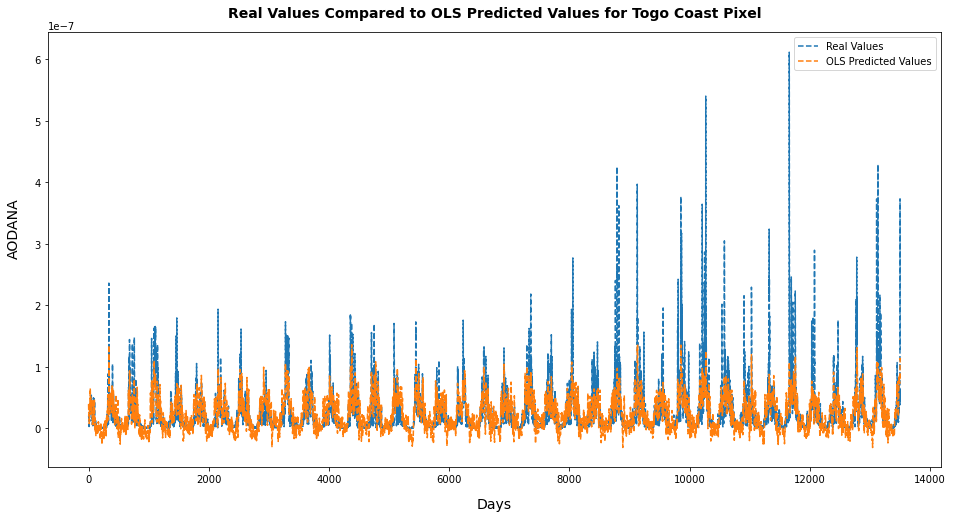

In [15]:
plot_ols_data(aod_reg_df, aod_reg_predictions, y_name= 'AODANA', x_name = 'Days', title='Real Values Compared to OLS Predicted Values for Togo Coast Pixel')

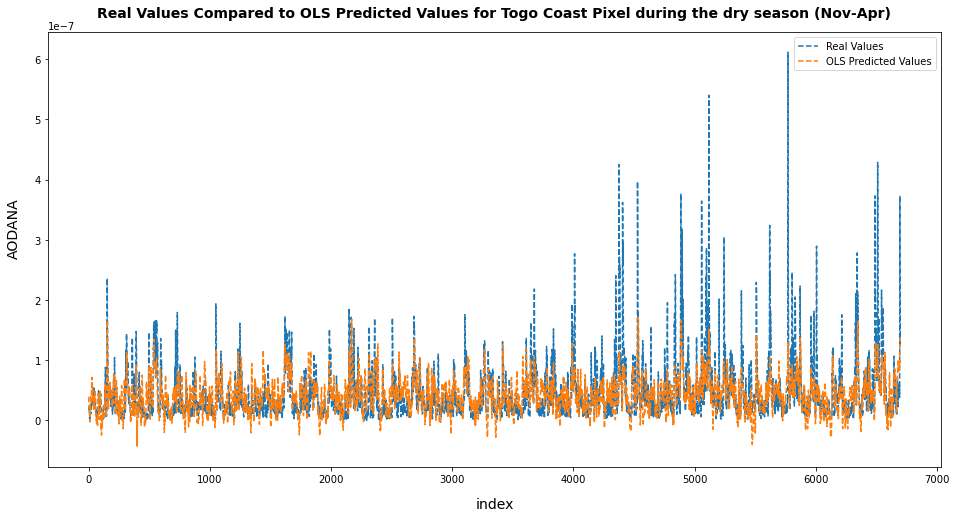

In [16]:
plot_ols_data(aod_reg_df[(aod_reg_df['dry_season']==True)], aod_reg_novapr_predictions, y_name= 'AODANA', x_name = 'index', title='Real Values Compared to OLS Predicted Values for Togo Coast Pixel during the dry season (Nov-Apr)')

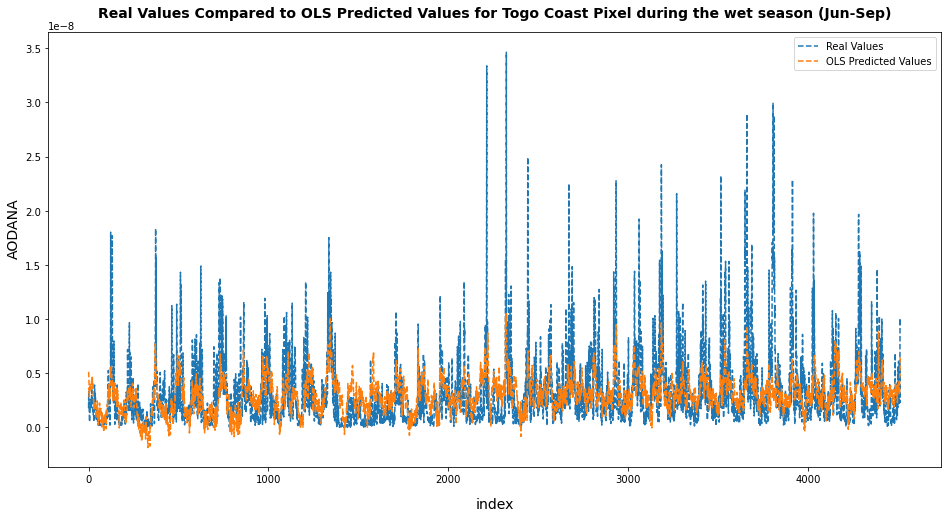

In [17]:
plot_ols_data(aod_reg_df[(aod_reg_df['wet_season']==True)], aod_reg_junsep_predictions, y_name= 'AODANA', x_name = 'index', title='Real Values Compared to OLS Predicted Values for Togo Coast Pixel during the wet season (Jun-Sep)')

In [18]:
from statsmodels.tsa.api import VAR

aod_model_novapr_var = VAR(aod_reg_df[(aod_reg_df['dry_season']==True)].iloc[: ,[0,3,14,15]])
aod_model_junsep_var = VAR(aod_reg_df[(aod_reg_df['wet_season']==True)].iloc[: ,[0,3,14,15]])

results_aod_novapr = aod_model_novapr_var.fit(10)
# results_aod_novapr.summary()
results_aod_junsep = aod_model_junsep_var.fit(10)
# results_aod_junsep.summary()

c:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


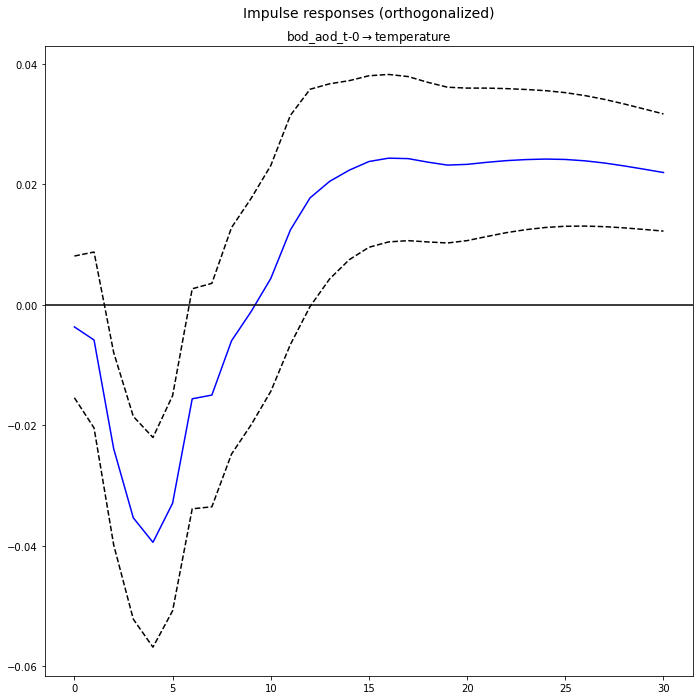

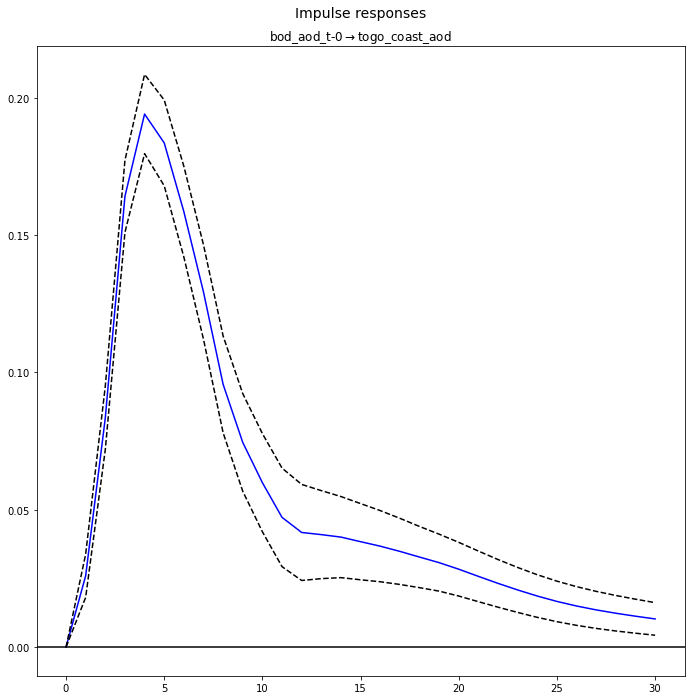

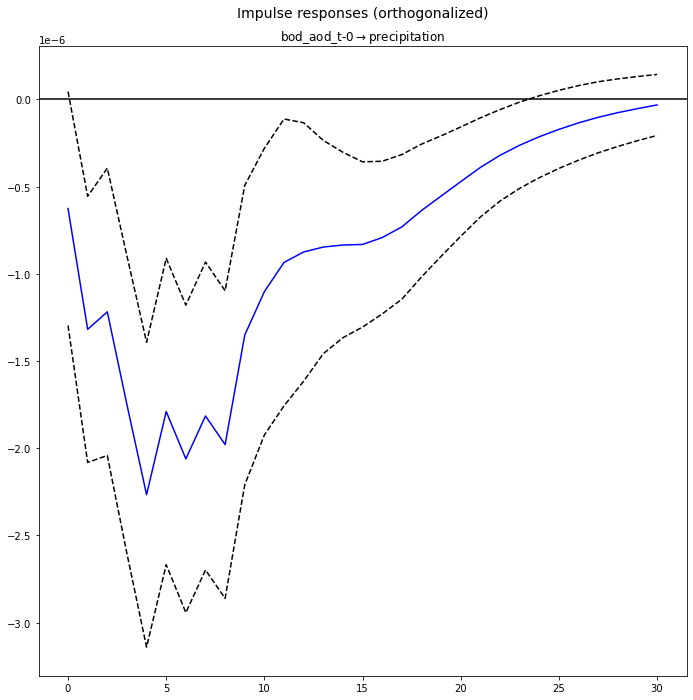

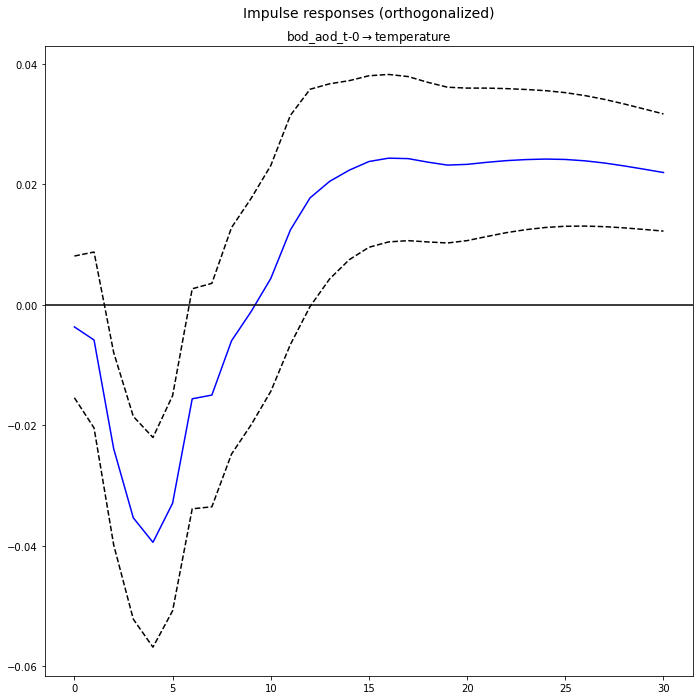

In [37]:
irf_aod_novapr = results_aod_novapr.irf(30)
irf_aod_novapr.plot(orth=False, impulse = 'bod_aod_t-0', response='togo_coast_aod')
irf_aod_novapr.plot(orth=True, impulse = 'bod_aod_t-0', response='precipitation')
irf_aod_novapr.plot(orth=True, impulse = 'bod_aod_t-0', response='temperature')
# irf_aod_novapr.plot(orth=True)

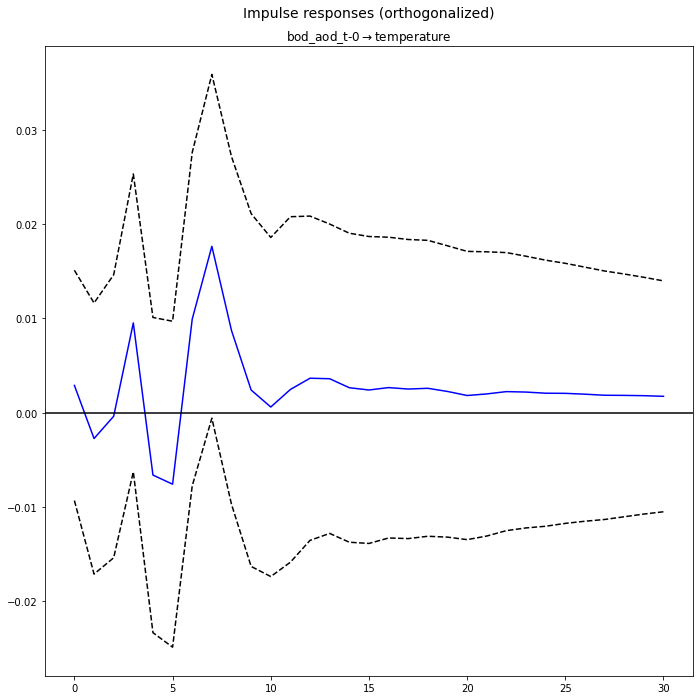

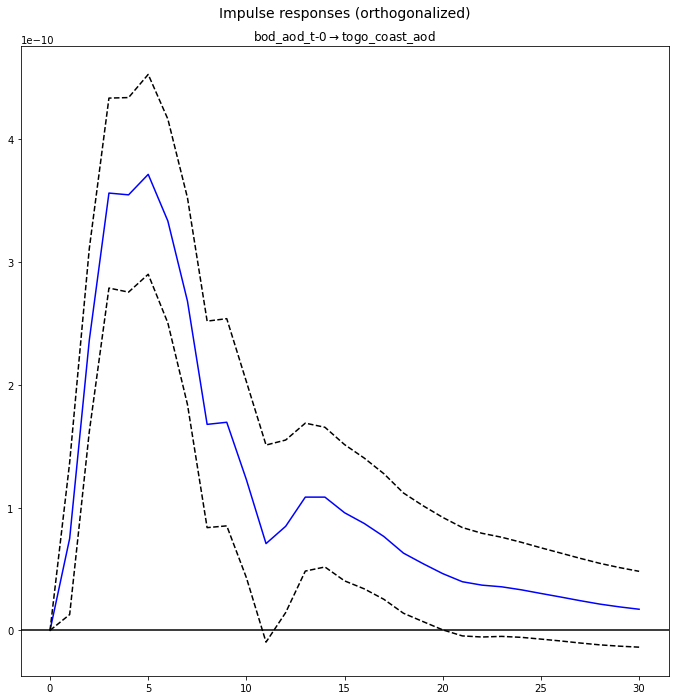

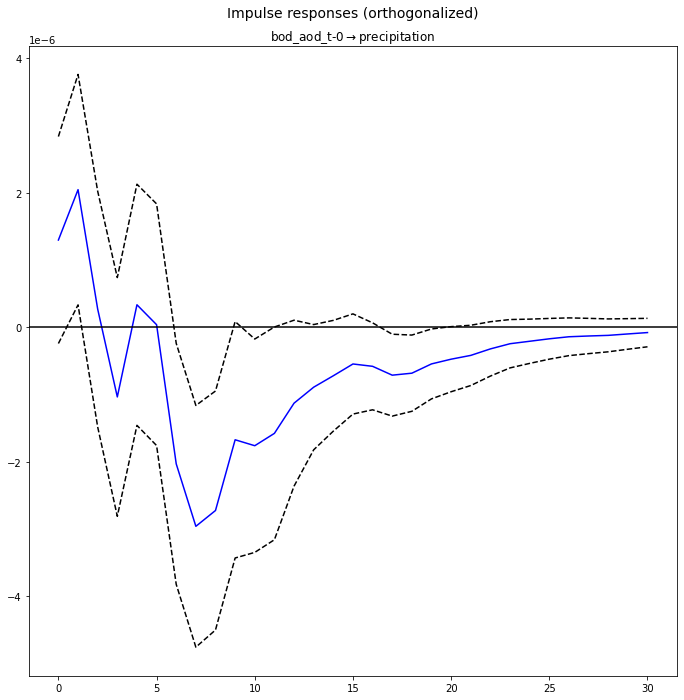

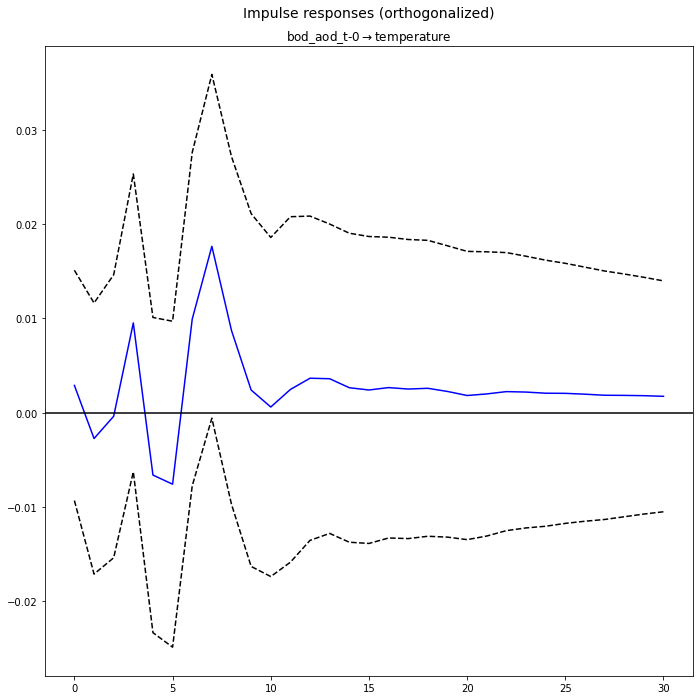

In [20]:
irf_aod_junsep = results_aod_junsep.irf(30)
irf_aod_junsep.plot(orth=True, impulse = 'bod_aod_t-0', response='togo_coast_aod')
irf_aod_junsep.plot(orth=True, impulse = 'bod_aod_t-0', response='precipitation')
irf_aod_junsep.plot(orth=True, impulse = 'bod_aod_t-0', response='temperature')
# irf_aod_junsep.plot(orth=True)

In [21]:
predicted_daily_aod_data = np.load(parent_directory + '\\processed_data\\predicted_daily_dust_data.npy')
r_squared_map = np.load(parent_directory + '\\processed_data\\r_squared_map.npy')
mse_array = np.load(parent_directory + '\\processed_data\\mse_array.npy')

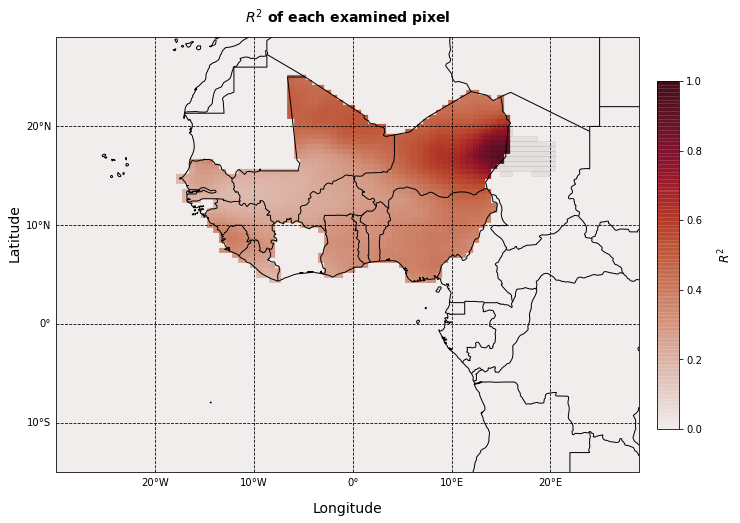

In [22]:
plot_merra_data(r_squared_map,
                west_africa_longitudes, west_africa_latitudes, title=r'$R^{2}$ of each examined pixel',
                date='', data_value=r'$R^{2}$', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = 1, unit = 1)

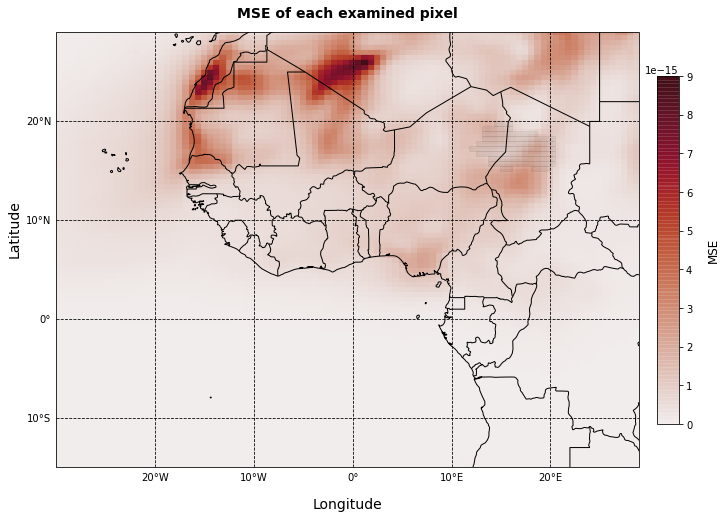

In [36]:
plot_merra_data(mse_array,
                west_africa_longitudes, west_africa_latitudes, title='MSE of each examined pixel',
                date='', data_value='MSE', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = 9, unit = 10**-15)

In [24]:
benin_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_ben.csv')
burkina_faso_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_bfa.csv')
gambia_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_gmb.csv')
ghana_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_gha.csv')
guinea_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_gin.csv')
liberia_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_lbr.csv')
mali_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_mli.csv')
niger_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_ner.csv')
nigeria_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_nga.csv')
sierra_leone_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_sle.csv')
senegal_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_sen.csv')
togo_population_df = pd.read_csv(parent_directory + '\\raw_data\\3.3_model_implementation\\population_estimates\\gpw_v4_admin_unit_center_points_population_estimates_rev11_tgo.csv')

In [25]:
population_array = np.load(parent_directory + '\\processed_data\\population_array.npy')

c:\Users\Daniel\Desktop\Bachelor_thesis\new_topic\Code\functions.py:821: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(['no data', '0.2', '0.4', '0.6', '0.8',r'$\geq 1$'])


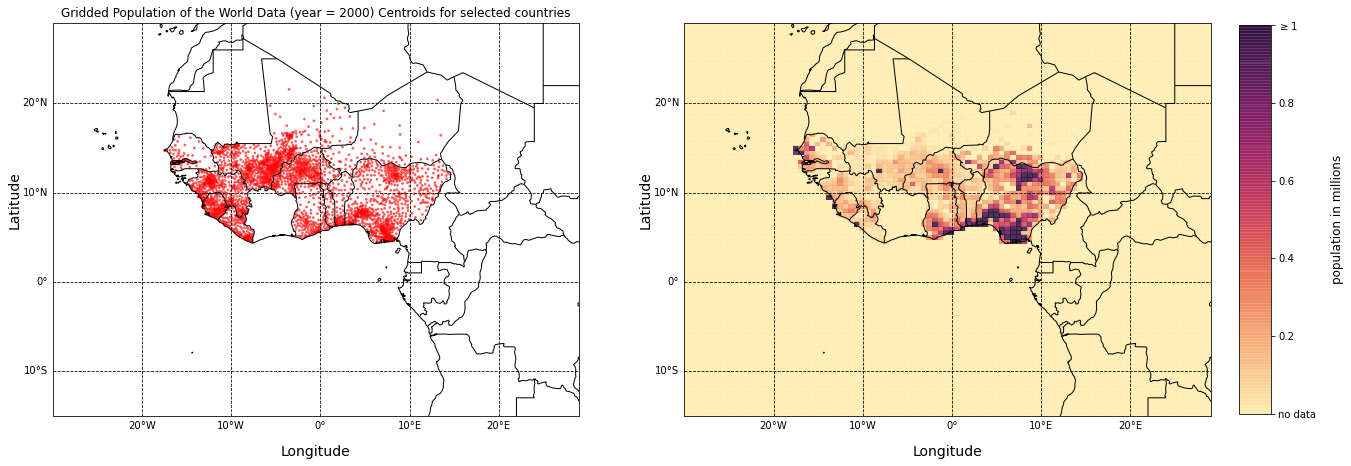

In [26]:
plot_gpw_data(population_array, west_africa_latitudes, west_africa_longitudes,
              extent=[-30,29,-15,29], borders = True,
              population_data = [benin_population_df, burkina_faso_population_df, gambia_population_df,
              ghana_population_df, guinea_population_df, liberia_population_df,
              mali_population_df, niger_population_df, nigeria_population_df,
              sierra_leone_population_df, senegal_population_df, togo_population_df])

The first outcome I consider is country-level economic growth. To estimate the impacts of
dust storms on growth, I exploit random year-to-year variation in dust exposure in a fixed-
effects regression:

Country-level regression
$$g_{cy} = \sum_{j=0}^{L} [ \beta_{j}D_{cy-j} + \rho_{j}C_{cy-j} ] + \alpha_{0c} + \alpha_{1c}y + \alpha_{2c}y^{2} + \epsilon_{cy}$$
---
Where:
$$ D_{cy-j} = \text{measure of dust exposure}$$
$$ \text{instrumented by long-range transported dust, since variable is likely endogneous to eocnomic growth} $$
$$ C_{cy-j} = \text{climate, includes temperature and precipitation over the year} $$
$$ \beta_{0} = \text{captures the level effect of dust exposure on economic production} $$
$$ \Omega_{L} = \sum_{j=0}^{L} \beta_{j} = \text{captures the effect on GDP over L years} $$
$$ \epsilon_{cy} \text{ are allowed to be arbitrarily correlated across 5 years for the same country and across countries with centroids that are within 1000km of each other for the same year} $$

In [27]:
#import gdp data

df_pwt = pd.read_csv(parent_directory + '\\processed_data\\df_pwt.csv')
df_pwt_growth = pd.read_csv(parent_directory + '\\processed_data\\df_pwt_growth.csv')
df_wbdi = pd.read_csv(parent_directory + '\\processed_data\\df_wbdi.csv')
df_wbdi_growth = pd.read_csv(parent_directory + '\\processed_data\\df_wbdi_growth.csv')
df_wbdi_per_cap_growth = pd.read_csv(parent_directory + '\\processed_data\\df_wbdi_per_cap_growth.csv')
df_mpd = pd.read_csv(parent_directory + '\\processed_data\\df_mpd.csv')
df_mpd_growth = pd.read_csv(parent_directory + '\\processed_data\\df_mpd_growth.csv')
df_mpd_pop = pd.read_csv(parent_directory + '\\processed_data\\df_mpd_pop.csv')

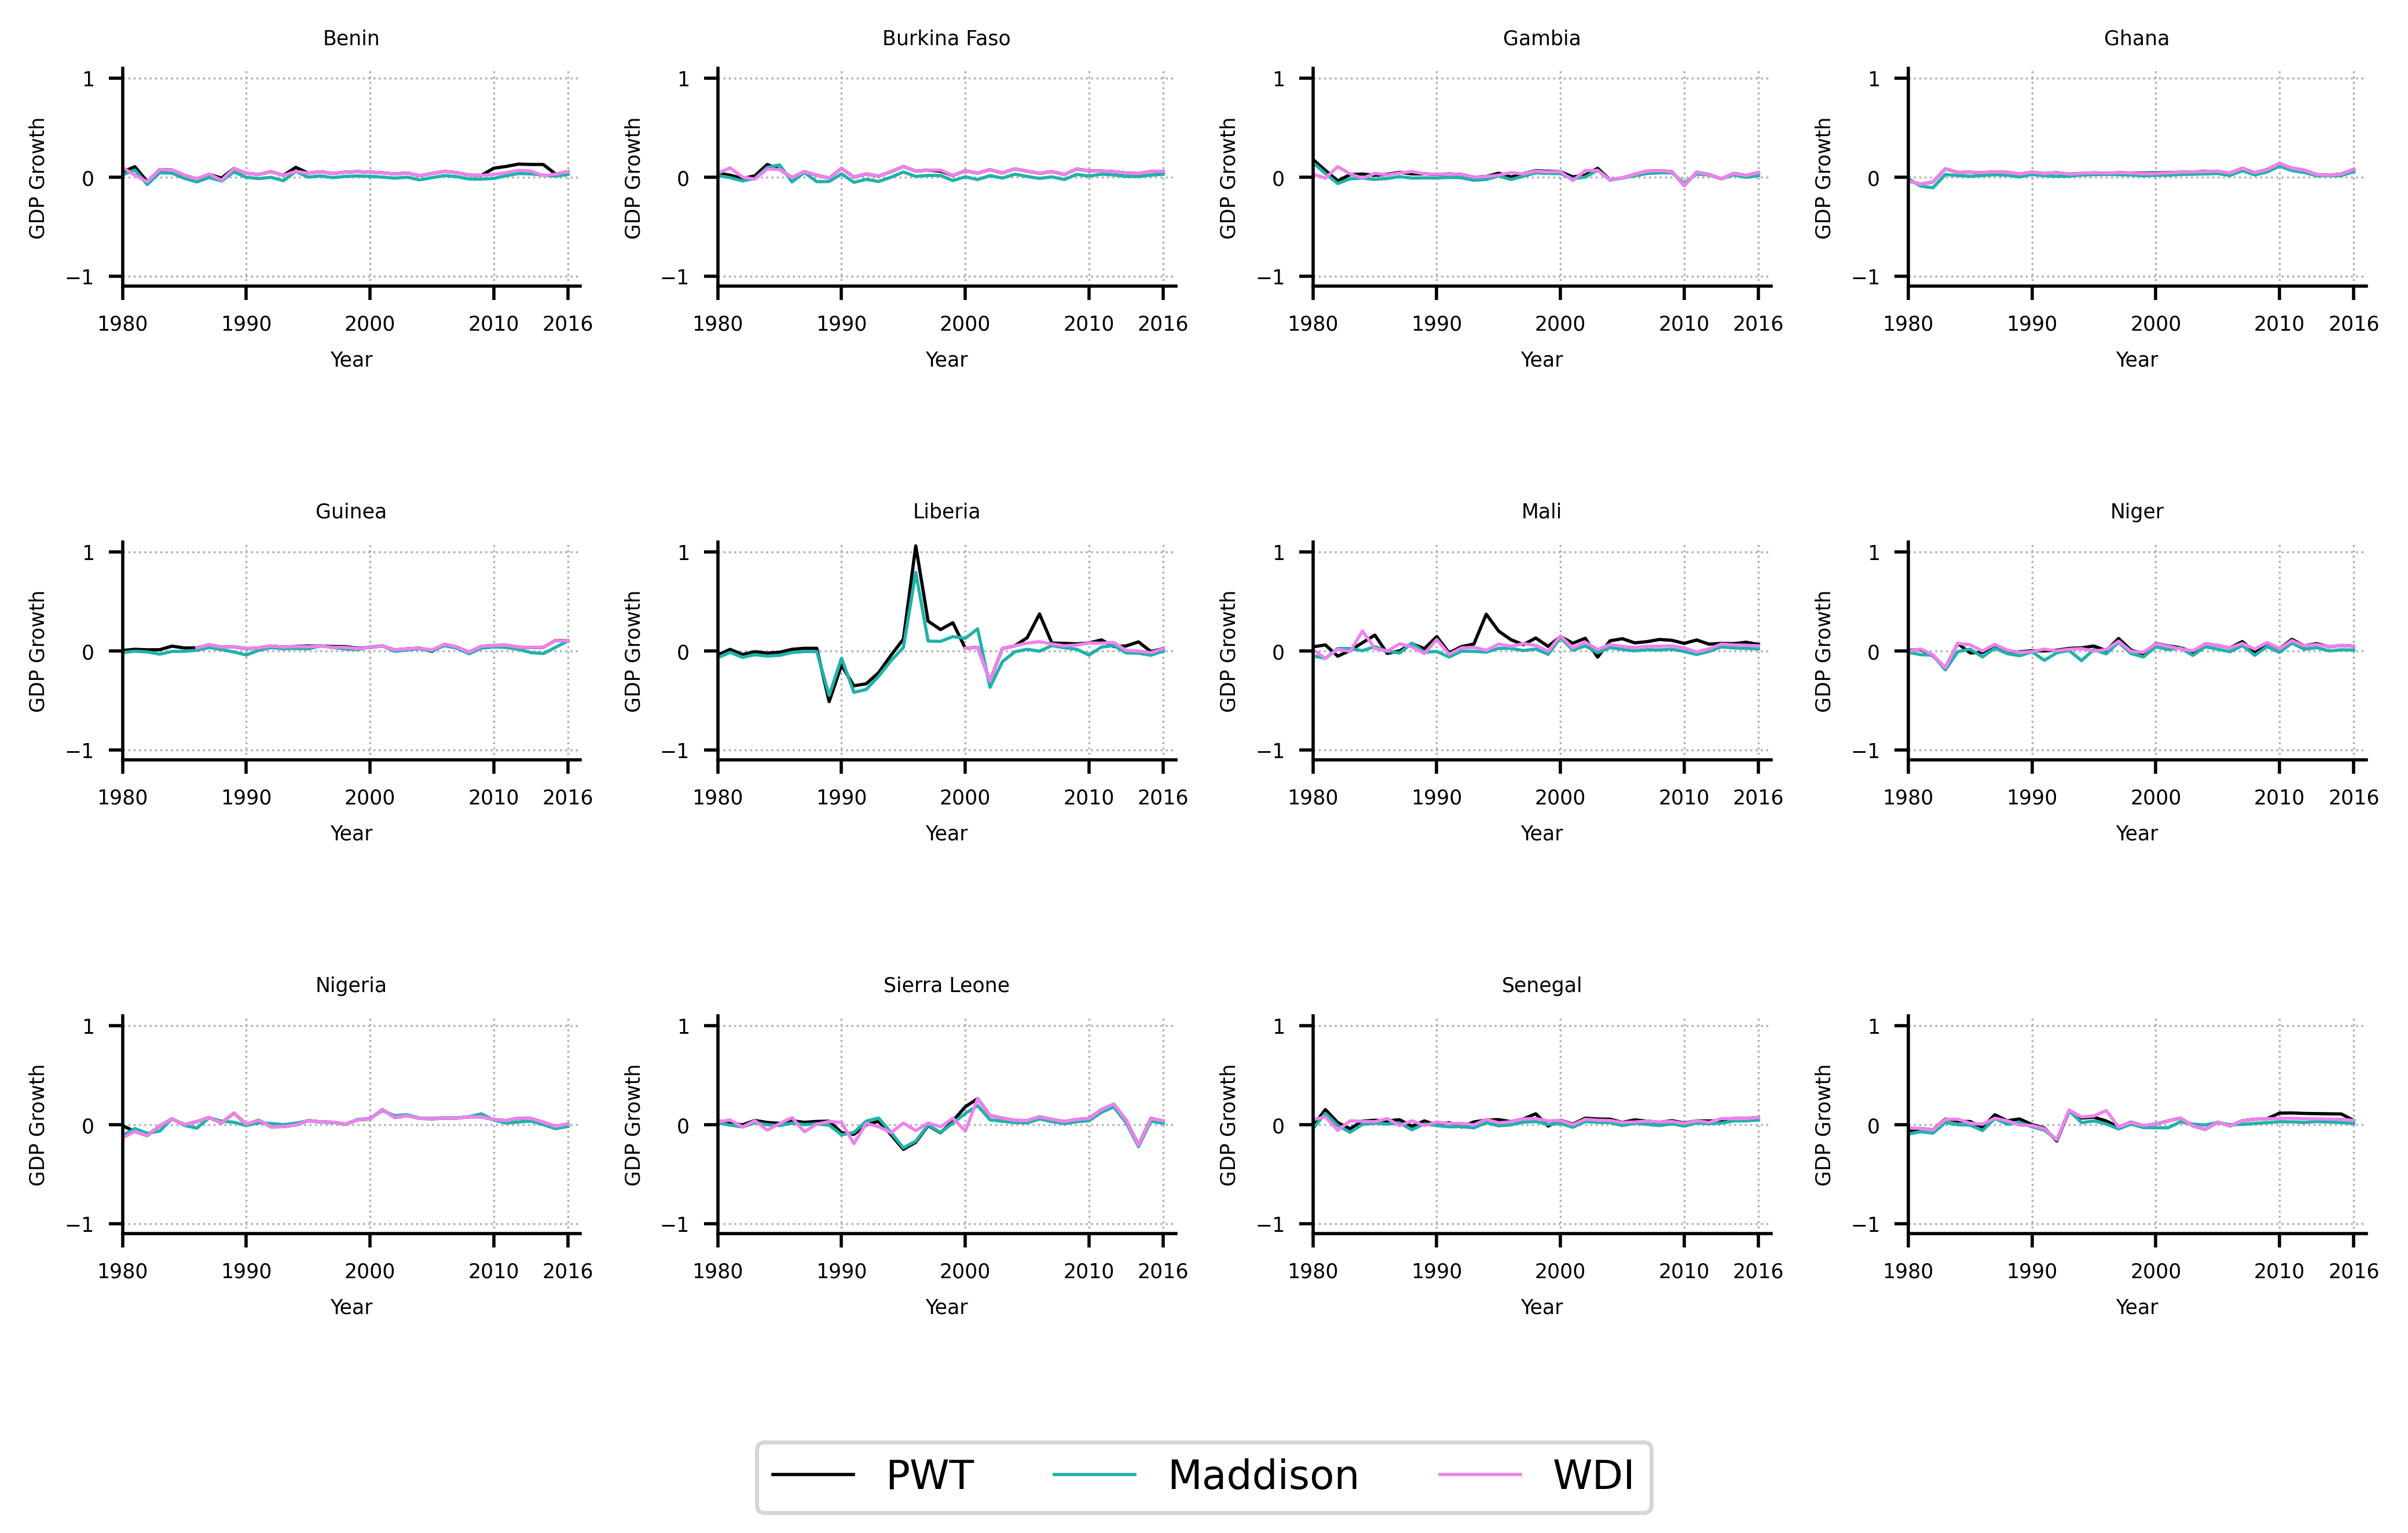

In [28]:
plot_outcome_data(df_pwt_growth, df_mpd_growth, df_wbdi_growth,
                  ylim = [-1.1,1.1], yticks = [-1,0,1], xlim = [1980, 2017], xticks = [1980,1990,2000,2010,2016],
                  xlabel = 'Year', ylabel = 'GDP Growth')

### 4.2 First Stage Country-Level

$$D_{cy} = \sum_{k=0}^{L} [ \eta_{k}\hat{D}_{cy-k} + \psi{C}_{cy-k} ] + \alpha_{1c}y + \alpha_{2c}y^{2} + \alpha_{c} + \nu_{cy}$$
---
Where:
$$ D_{cy} = \text{observed dry-season dust over country c in year y}$$
$$ \hat{D}_{cy-k} = \text{contemporaneous and lagged values of the aggregated predicted values of dry-season dust from Equation 3}$$
$$ C_{cy-k} = \text{contains population-weighted country-level temperature and precipitation} $$

In [29]:
combined_first_stage_df = pd.read_csv(parent_directory + '\\processed_data\\combined_first_stage_df.csv')

# combined_first_stage_df['year'] = pd.to_datetime(combined_first_stage_df['year'], format='%Y')

combined_first_stage_df_panel = combined_first_stage_df

combined_first_stage_df_panel=combined_first_stage_df.set_index('country', append=True)
#swap indexes
combined_first_stage_df_panel.index = combined_first_stage_df_panel.index.swaplevel(0,1)



In [30]:
combined_first_stage_df_panel

Unnamed: 0  centroid_lat  centroid_lon  year  pow_year  \
country                                                               
benin   0             0      9.307690      2.315834  1980   3920400   
        1             1      9.307690      2.315834  1981   3924361   
        2             2      9.307690      2.315834  1982   3928324   
        3             3      9.307690      2.315834  1983   3932289   
        4             4      9.307690      2.315834  1984   3936256   
...                 ...           ...           ...   ...       ...   
togo    439         439      8.619543      0.824782  2012   4048144   
        440         440      8.619543      0.824782  2013   4052169   
        441         441      8.619543      0.824782  2014   4056196   
        442         442      8.619543      0.824782  2015   4060225   
        443         443      8.619543      0.824782  2016   4064256   

             aod_wt_yr_t-0  aod_wt_yr_t-1  aod_wt_yr_t-2  aod_wt_yr_t-3  \
country                                                                   
benin   0         0.004499            NaN            NaN            NaN   
        1         0.004538       0.004499            NaN            NaN   
        2         0.005754       0.004538       0.004499            NaN   
        3         0.005785       0.005754       0.004538       0.004499   
        4         0.004915       0.005785       0.005754       0.004538   
...                    ...            ...            ...            ...   
togo    439       0.020445       0.018721       0.018559       0.018729   
        440       0.015954       0.020445       0.018721       0.018559   
        441       0.015996       0.015954       0.020445       0.018721   
        442       0.022272       0.015996       0.015954       0.020445   
        443       0.020467       0.022272       0.015996       0.015954   

             aod_wt_yr_t-4  ...  dust_wt_yr_t-2  dust_wt_yr_t-3  \
country                     ...                                   
benin   0              NaN  ...             NaN             NaN   
        1              NaN  ...             NaN             NaN   
        2              NaN  ...    3.762678e-10             NaN   
        3              NaN  ...    4.374410e-10    3.762678e-10   
        4         0.004499  ...    3.610079e-10    4.374410e-10   
...                    ...  ...             ...             ...   
togo    439       0.021363  ...    1.109383e-09    1.392320e-09   
        440       0.018729  ...    1.584297e-09    1.109383e-09   
        441       0.018559  ...    1.617084e-09    1.584297e-09   
        442       0.018721  ...    1.071489e-09    1.617084e-09   
        443       0.020445  ...    1.103915e-09    1.071489e-09   

             dust_wt_yr_t-4  dust_wt_yr_t-5  dust_pred_wt_dry_t-0  \
country                                                             
benin   0               NaN             NaN          5.107581e-10   
        1               NaN             NaN          7.294132e-10   
        2               NaN             NaN          7.012491e-10   
        3               NaN             NaN          8.526674e-10   
        4      3.762678e-10             NaN          6.206740e-10   
...                     ...             ...                   ...   
togo    439    1.964752e-09    1.972669e-09          2.821761e-09   
        440    1.392320e-09    1.964752e-09          1.798649e-09   
        441    1.109383e-09    1.392320e-09          1.612062e-09   
        442    1.584297e-09    1.109383e-09          2.475308e-09   
        443    1.617084e-09    1.584297e-09          2.555299e-09   

             dust_pred_wt_dry_t-1  dust_pred_wt_dry_t-2  dust_pred_wt_dry_t-3  \
country                                                                         
benin   0                     NaN                   NaN                   NaN   
        1            5.107581e-10                   NaN                   NaN   
        2          

In [31]:
from linearmodels import PanelOLS
# fe_mod = PanelOLS(df['real_dust_t-0'],sm.add_constant(df[['pred_dust_t-0', 'pred_dust_t-1','precipitation_t-0','precipitation_t-1', 'temperature_t-0','temperature_t-1', 'year', 'pow_year']]), entity_effects=True)
fe_mod = PanelOLS(combined_first_stage_df_panel['real_dust_t-0'],sm.add_constant(combined_first_stage_df_panel[['pred_dust_t-0','precipitation_t-0','temperature_t-0', 'year']]), entity_effects=True)
fe_res = fe_mod.fit(cov_type='clustered', cluster_entity=True)
# fe_res = fe_mod.fit()

KeyError: 'real_dust_t-0'

In [ ]:
fe_res.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          PanelOLS Estimation Summary                           
================================================================================
Dep. Variable:          real_dust_t-0   R-squared:                        0.2749
Estimator:                   PanelOLS   R-squared (Between):             -12.824
No. Observations:                 384   R-squared (Within):               0.2749
Date:                Thu, May 05 2022   R-squared (Overall):             -12.023
Time:                        14:01:48   Log-likelihood                    1895.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      34.873
Entities:                          12   P-value                           0.0000
Avg Obs:                       32.000   Distribution:                   F(4,368)
Min Obs:                       32.000                                           
Max Obs:                       32.000   F-statistic (robust):             51.694
                                        P-value                           0.0000
Time periods:                     384   Distribution:                   F(4,368)
Avg Obs:                       1.0000                                           
Min Obs:                       1.0000                                           
Max Obs:                       1.0000                                           
                                                                                
                                 Parameter Estimates                                 
=====================================================================================
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                -0.1303     0.0953    -1.3673     0.1724     -0.3176      0.0571
pred_dust_t-0         1.7500     0.2410     7.2618     0.0000      1.2761      2.2239
precipitation_t-0    -1952.1     768.77    -2.5393     0.0115     -3463.8     -440.37
temperature_t-0       0.0049     0.0116     0.4245     0.6714     -0.0179      0.0277
year               4.888e-05  2.953e-05     1.6556     0.0986  -9.176e-06      0.0001
=====================================================================================

F-test for Poolability: 1.6207
P-value: 0.0908
Distribution: F(11,368)

Included effects: Entity
"""

In [ ]:
from functions import get_regional_mean_data, get_time_span_region_data

aod_daily_data = np.load(parent_directory + '\\processed_data\\aod_daily_data.npy') 
precipitation_daily_data = np.load(parent_directory + '\\processed_data\\precipitation_daily_data.npy')
temperature_daily_data = np.load(parent_directory + '\\processed_data\\temperature_daily_data.npy')
bodele_region_pixels = return_region_pixel_array(region_name='bodele')
daily_bodele_aod_data = get_regional_mean_data(get_time_span_region_data(aod_daily_data, bodele_region_pixels))

In [ ]:
from functions import hourly_data_to_daily_mean


predicted_daily_dust_data = np.load(parent_directory + '\\processed_data\\predicted_daily_dust_data.npy') 
r_squared_map = np.load(parent_directory + '\\processed_data\\r_squared_map_dust.npy') 
mse_array = np.load(parent_directory + '\\processed_data\\mse_array.npy') 



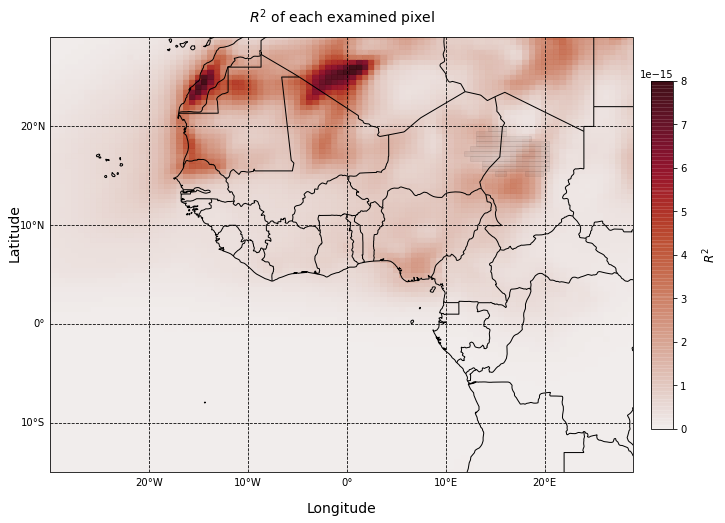

In [ ]:
plot_merra_data(mse_array,
                west_africa_longitudes, west_africa_latitudes, title=r'$R^{2}$ of each examined pixel',
                date='', data_value=r'$R^{2}$', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = 8, unit = 10**-15)

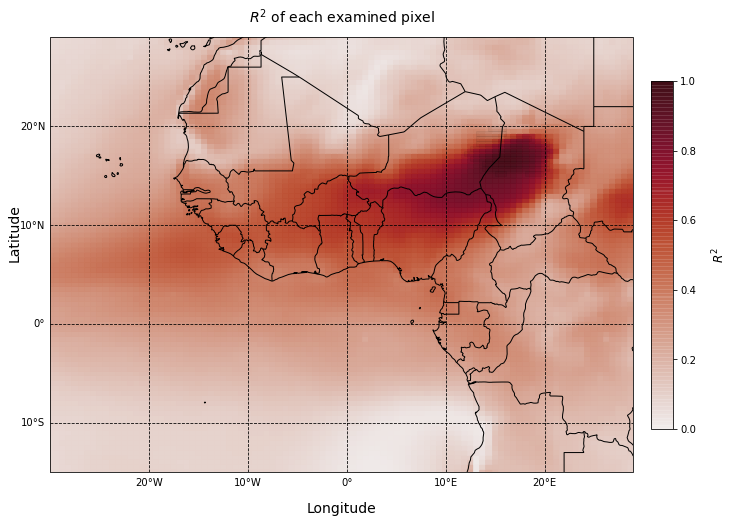

In [ ]:
plot_merra_data(r_squared_map,
                west_africa_longitudes, west_africa_latitudes, title=r'$R^{2}$ of each examined pixel',
                date='', data_value=r'$R^{2}$', extent=[-30,29,-15,29], borders = True, add_bodele_source_exclusive= True, add_bodele_source_exclusive_alpha=.05,
                bodele = False, plot_grids = True, cbar_color = cmocean.tools.lighten(cmo.amp, 0.85), cbar_max = 1, unit = 1)

In [398]:
# predicted_daily_dust_data, r_squared_map_dust = daily_dust_country_regression_total_const(dust_daily_data, daily_bodele_dust_data, precipitation_daily_data, temperature_daily_data, daily_junsep_indices, daily_novapr_indices)

C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Daniel\anaconda3\envs\bachelor_econ\lib\site-packages\statsmodels\base\model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 15, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
C:\Users